In [35]:
%pylab inline
import netCDF4 as nc
import cartopy.crs as ccrs
from pathlib import Path

import matplotlib as mpl
mpl.rc('lines', linewidth=1)
mpl.rc('font', size=12)
mpl.rc('axes', linewidth=1.5)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['figure.figsize'] = 8, 6


import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Emergent Constraints in CMIP5 Data

## Movitation


### Climate Sensitivity

What is true __true__ equilibrium warming of our planet due to a doubling of CO$_2$.

### Emergent Constraints

Approach: Can we use the spread of models...

## Aim

Investigate relevant emergent constraints in CMIP5 data and test their reliability.

We begin by _replicating_ the results from P. M. Cox, C. Huntingford, M. S. Williamson, _Emergent constraint on equilibrium climate sensitivity from global temperature variability_, Nature, 2018.

![title](cox.png)

Exploration: sea-land temperature variability.

## Introducing the Data

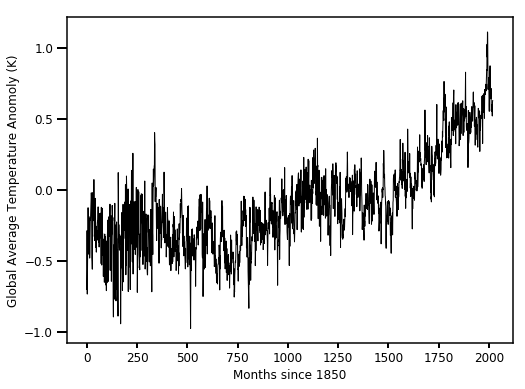

In [36]:
# Load Observational Dataset
hist_temp = np.loadtxt('HadCRUT4_month.txt', usecols=1)
plt.plot(hist_temp, 'k-', label='HadCRUT4 Reanalysis');
plt.xlabel('Months since 1850');
plt.ylabel('Global Average Temperature Anomoly (K)');

## Steps

* Detrend by subtracting a moving window average.
* Measuring the resulting standard deviation.
* Repeat for each CMIP5 Model

In [37]:
#Prepare to read in CMIP5 Info

data_names = ['tas_Amon_ACCESS1-0_historical*.nc', # 3.8
    'tas_Amon_bcc-csm1-1_historical*.nc', # 2.8 
    'tas_Amon_BNU-ESM_historical*.nc', # 4.1
    'tas_Amon_CanESM2_historical*.nc', # 3.7
    'tas_Amon_CCSM4_historical*.nc', # 2.9
    'tas_Amon_GFDL-CM3_historical*.nc', # 4.0
    'tas_Amon_GISS-E2-H_historical*.nc', # 2.3
    'tas_Amon_HadGEM2-ES_historical*.nc', # 4.6
    'tas_Amon_inmcm4_historical*.nc', # 2.1
    'tas_Amon_IPSL-CM5A-LR_historical*.nc', # 4.1
    'tas_Amon_MIROC-ESM-CHEM_historical*.nc', #4.7
    'tas_Amon_MIROC5_historical*.nc', #2.7
    'tas_Amon_MPI-ESM-LR_historical*.nc', # 3.6
    'tas_Amon_MRI-CGCM3_historical*.nc', # 2.6
    'tas_Amon_NorESM1-M_historical*.nc'] # 2.8

labels = ['ACCESS1-0','bcc-csm1-1','BNU-ESM','CanESM2','CCSM4', 'GFDL-CM3', 
    'GISS-E2-H', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'MIROC-ESM-CHEM',
    'MIROC5', 'MPI-ESM-LR','MRI-CGCM3', 'NorESM1-M'] 
cs =  [3.8, 2.8, 4.1, 3.7, 2.9, 
       4.0, 2.3, 4.6, 2.1, 4.1, 4.7, 2.7, 3.6, 2.6,  2.8]
fast_variable = np.zeros(len(data_names))


In [4]:
# Script for correct averaging of lat-lon gridded data.
def grid_areas(ds):
    lats = ds.variables['lat'][:]
    res = 180/ds.variables['lat'].shape[0]

    def sin_d(degrees):
        return np.sin(degrees / 180 * np.pi)

    s = (sin_d(lats + (res / 2)) - sin_d(lats - (res / 2))) / 2
    s[0] = 1 -  sin_d(90 - (res / 2))
    s[-1] = 1 - sin_d(90 - res / 2)
    areas = np.zeros([ds.variables['lat'].shape[0], ds.variables['lon'].shape[0]])
    for i in range(ds.variables['lon'].shape[0]):
        areas[:, i] = s / ds.variables['lon'].shape[0]
        
    return areas

# Script for moving window detrending of timeseries data (for the temperatures)

def Detrend(input_data):
    p=40
    q=20
    n = int(np.floor(len(input_data)/12))
    data_m = np.zeros([12,n])
    data_m_temp=np.zeros([12,n-p,p])
    data_m_mean = np.zeros([12,n-p])
    data_m_detrend_point = np.zeros([12,n-p])
    for k in range(0,12):
        data_m[k] = [input_data[e*12+k] for e in range(0,n)]
        for j in range(0,n-p):
            data_m_temp[k][j]=[data_m[k][i+j] for i in range(0,p)]
            data_m_mean[k][j]=np.mean(data_m_temp[k][j])
            data_m_detrend_point[k][j] = data_m[k][j+q]-np.mean(data_m_temp[k][j])
    data_all=np.transpose(data_m_detrend_point)
    data_all=np.ravel(data_all)
    return data_all

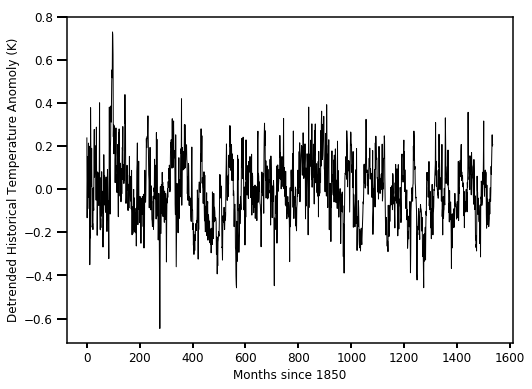

In [78]:
plt.plot(Detrend(hist_temp), 'k-', label='HadCRUT4 Reanalysis');
plt.xlabel('Months since 1850');
plt.ylabel('Detrended Historical Temperature Anomoly (K)');
hist_std = np.std(Detrend(hist_temp))

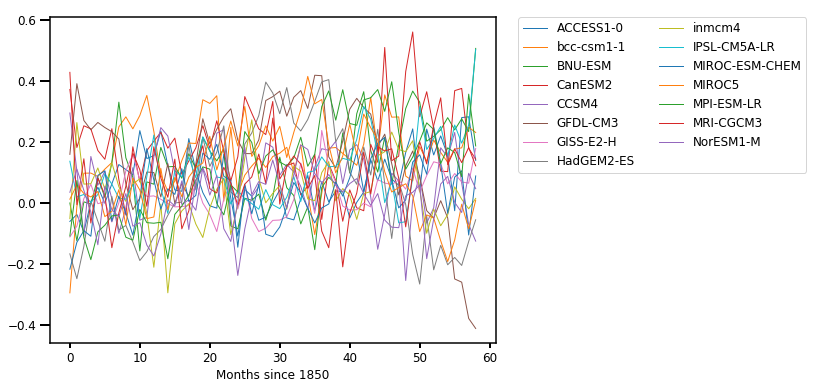

In [85]:
for i in range(len(data_names)):
    data_path = Path('/Users/g/Documents/CMIP5/')
    files = sorted(data_path.glob(data_names[i]))
    data = [nc.Dataset(f) for f in files]
    temperatures = np.concatenate([d['tas'][:] for d in data])
    
    #Calculate the global averate temperature
    temp_time = np.sum(temperatures * grid_areas(data[0]), axis=(1,2))
    
    # Calculate the observable - unforced variability
    fast_variable[i] = np.std(Detrend(temp_time))
    
    plt.plot(Detrend(temp_time)[1:60], label = labels[i] )
plt.xlabel('Months since 1850')
plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Results


In [63]:
# Setting up colors
number = 15
cmap = plt.get_cmap('gist_ncar')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

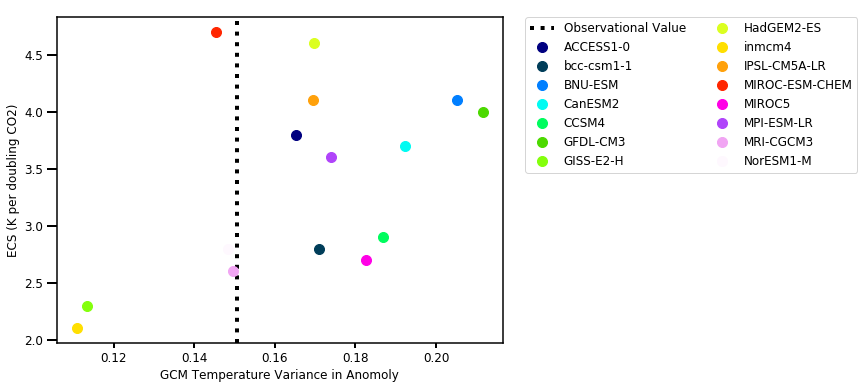

In [84]:
plt.axvline(x=hist_std, color = 'k', linewidth = 4, linestyle = 'dotted', label = 'Observational Value')

for i in range(len(data_names)):
    plt.plot(fast_variable[i],cs[i], color = colors[i], marker = '.', markersize = 20, linestyle = 'none', label = labels[i] )

plt.ylabel('ECS (K per doubling CO2)')
plt.xlabel('GCM Temperature Variance in Anomoly')
plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


In [74]:
p = np.polyfit(fast_variable, cs, deg=1, full=True)